In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
ds = pd.read_csv('C:/Users/balac/Downloads/Food_data Final Project.csv')
df = pd.DataFrame(ds)

# Data Cleaning

In [114]:
df.isnull().sum()

cooking_date         0
user_uuid            0
category             0
chef_id              0
language             0
level                0
challenge_id         0
country              0
subscription_date    0
platform             0
recipe_id            0
stars                0
dtype: int64

There are not missing values in the dataset, so no need to do any data cleaning.
<br> Let's check if the columns have duplicates or only unique values.

In [116]:
df.nunique()

cooking_date         561
user_uuid            242
category               7
chef_id               23
language               3
level                  3
challenge_id           4
country                3
subscription_date    221
platform               3
recipe_id            593
stars                  5
dtype: int64

We can see that this platform is used only by users from 3 countries (Italy, United Kingdom and France) and the recipes received all the possible rates from 1 to 5.
<br> To improve the readability and avoid confusion with the language column, let's change the names of the countries from their acronyms (it, fr, uk) into their full names. 

In [5]:
def edit_country_name(row):
    country_old = row['country']
    if country_old == 'it':
        country = 'Italy'
    elif country_old == 'fr':
        country = 'France'
    elif country_old == 'uk':
        country = 'UnitedKingdom'
    else:
        country = 'Unknown'
    row['country'] = country
    return row

In [7]:
df = df.apply(edit_country_name, axis = 1)

In [122]:
df.head(6)

,cooking_date,user_uuid,category,chef_id,language,level,challenge_id,country,subscription_date,platform,recipe_id,stars
0,4-2-2023,82,smoothie,109,fr,intermediate,1,France,21-1-2022,pc,1251,1
1,22-6-2023,123,ethnic,122,fr,advanced,3,France,19-9-2021,mobile,6347,1
2,8-10-2021,186,smoothie,105,fr,basic,0,France,12-8-2020,tv,1152,5
3,4-3-2021,202,ethnic,118,fr,basic,3,France,4-2-2020,tv,6140,2
4,18-1-2022,216,lunch,103,en,intermediate,1,UnitedKingdom,8-10-2021,pc,6248,1
5,11-4-2022,169,smoothie,103,it,advanced,1,Italy,16-6-2021,mobile,1354,5


Therefore, let's convert the columns with dates in the format YYYY-MM-DD in order to export the clean file and create a SQL Database from it.

In [9]:
# Pandas decides the format (dayfirst=True can interpret correctly also days with only a number)

df['cooking_date'] = pd.to_datetime(df['cooking_date'], dayfirst=True, errors='coerce')
df['subscription_date'] = pd.to_datetime(df['subscription_date'], dayfirst=True, errors='coerce')

In [130]:
df.head(3)

,cooking_date,user_uuid,category,chef_id,language,level,challenge_id,country,subscription_date,platform,recipe_id,stars
0,2023-02-04,82,smoothie,109,fr,intermediate,1,France,2022-01-21,pc,1251,1
1,2023-06-22,123,ethnic,122,fr,advanced,3,France,2021-09-19,mobile,6347,1
2,2021-10-08,186,smoothie,105,fr,basic,0,France,2020-08-12,tv,1152,5


In [132]:
print(df.dtypes)

cooking_date         datetime64[ns]
user_uuid                     int64
category                     object
chef_id                       int64
language                     object
level                        object
challenge_id                  int64
country                      object
subscription_date    datetime64[ns]
platform                     object
recipe_id                     int64
stars                         int64
dtype: object


In [11]:
df.to_csv('food_data_clean.csv', index=False)

In [138]:
from IPython.display import FileLink

FileLink('food_data_clean.csv')

C:\Users\balac\food_data_clean.csv

# Data Visualization

Let's first calculate the average rating per category and level.

C:\Users\balac\AppData\Local\Temp\ipykernel_7856\1010841878.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


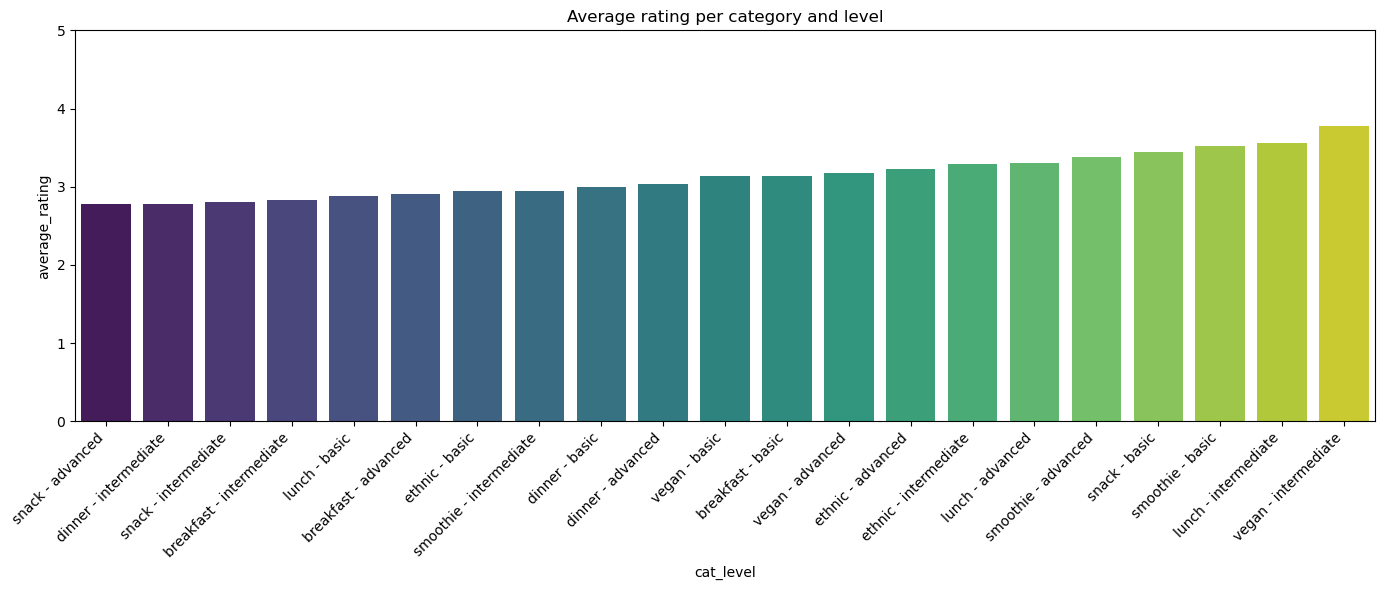

In [17]:
average_rating = df.groupby(['category', 'level'])['stars'].mean().round(2).reset_index(name='average_rating')

# Step 2: Create the combined column 'cat_level'
average_rating['cat_level'] = average_rating['category'] + ' - ' + average_rating['level']

# Step 3: Order the DataFrame per ascending average_rating
average_rating = average_rating.sort_values(by='average_rating', ascending=True)

# Step 4: Customized order for the x axis
order = average_rating['cat_level']

# Step 5: Ordered chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_rating,
    x='cat_level',
    y='average_rating',
    palette='viridis'
)
plt.title('Average rating per category and level')
plt.ylim(0, 5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This analysis shows us that the highest average rating in all levels is for the categories vegan and smoothie, which though were never in the highest positions of the SQL queries. 
<br>Ethnic is still the most popular one with high average ratings.
<br>Let's calculate then the total amount of recipes per level and category.

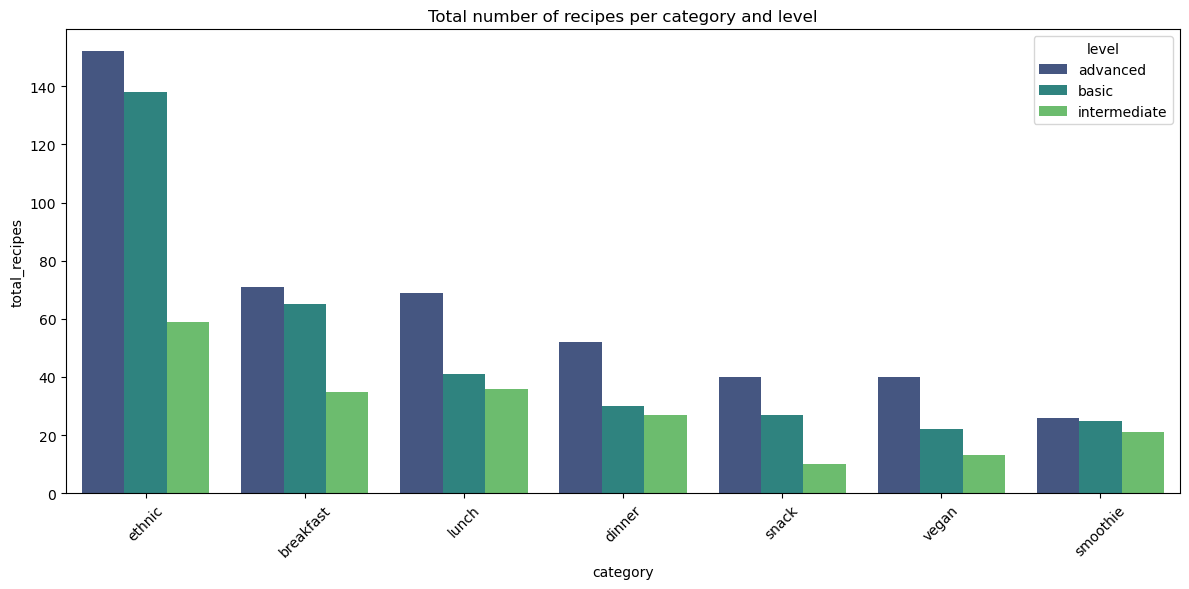

In [76]:
total_recipes = df[['category', 'level']].value_counts().reset_index(name='total_recipes')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=total_recipes,
    x='category',
    y='total_recipes',
    hue='level',
    palette='viridis'
)
plt.title('Total number of recipes per category and level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can deduct that the vegan and smoothie didn't figure out in the queries because they have the smallest amount of recipes in the dataset. 

Let's analyze if there is a correlation between the amount of subscriptions and of recipes added in the platform.
<br> In this analysis I want to know if during the months with more subscriptions it's more likely to happen that there are also more interactions with the recipes.

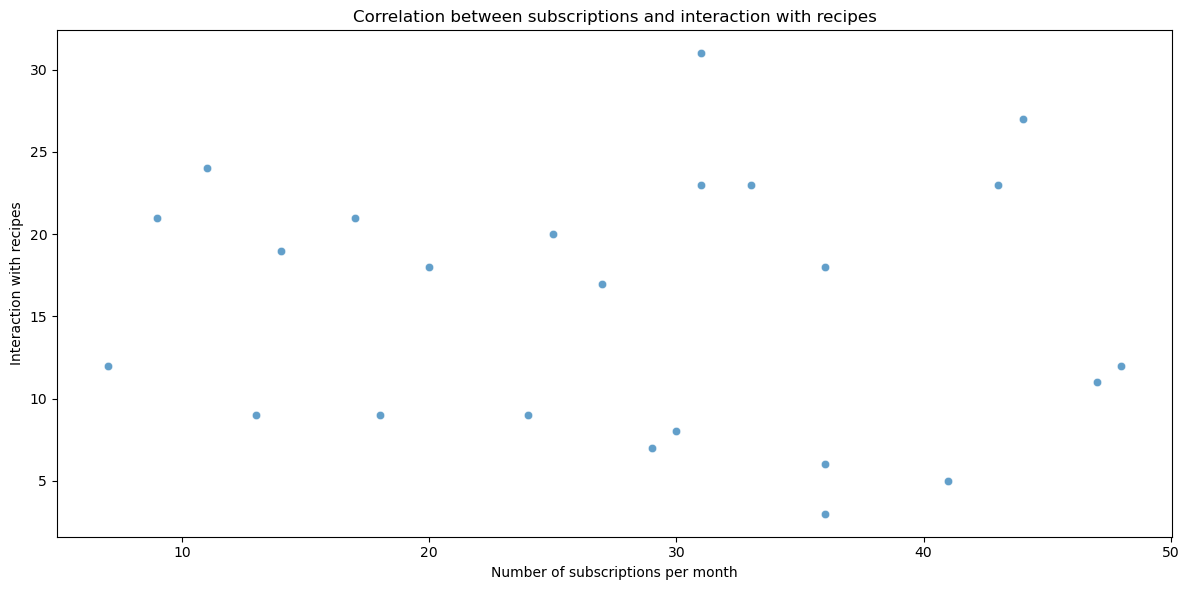

In [15]:
activity_by_subscription_date = df.groupby(df['subscription_date'].dt.to_period('M')).size() #counts how many users subscribed each month
recipes_by_month = df.groupby(df['cooking_date'].dt.to_period('M')).size() #counts how many recipes have been used each month

#Creation of a scatter plot to check if there is a correlation first of all combining the two series in a new dataframe

combined_data = pd.DataFrame({
    'activity_by_subscription_date': activity_by_subscription_date,
    'recipes_by_month': recipes_by_month
})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=combined_data,
    x='activity_by_subscription_date',
    y='recipes_by_month',
    alpha=0.7
)
plt.title('Correlation between subscriptions and interaction with recipes')
plt.xlabel('Number of subscriptions per month')
plt.ylabel('Interaction with recipes')
plt.tight_layout()
plt.show()

There is no correlation. So this could also mean that the old users keep interacting with the recipes during the time, whereas the new users start interacting more after a while.
<br> For a better understanding of the two variables let's create a line chart which compares the two.

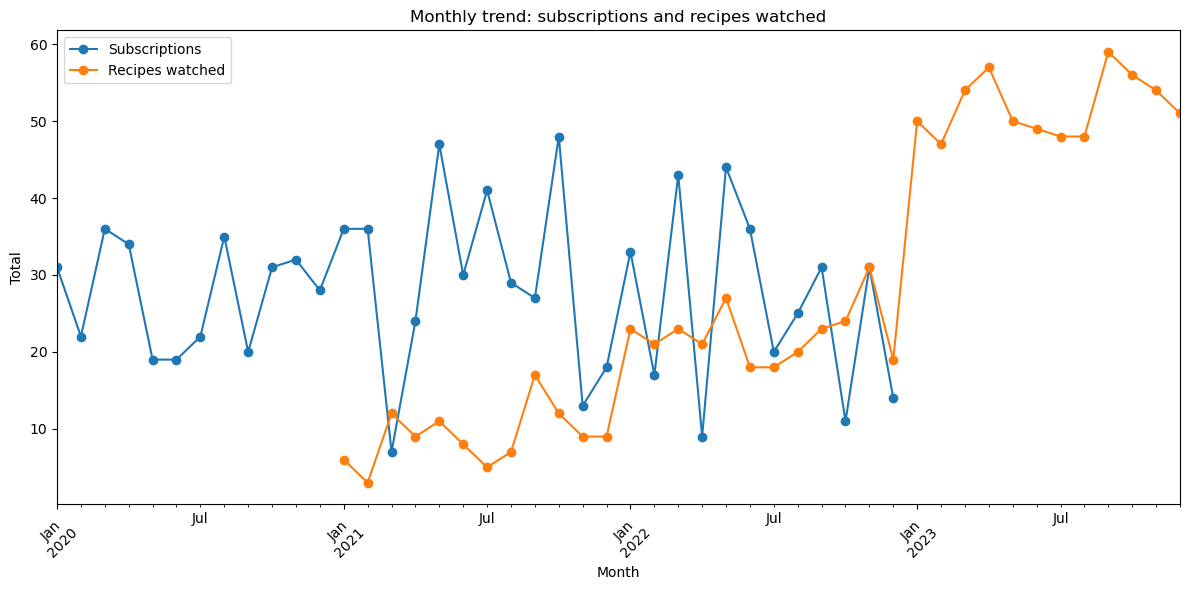

In [99]:
combined_data.plot(figsize=(12, 6), marker='o')
plt.title('Monthly trend: subscriptions and recipes watched')
plt.xlabel('Month')
plt.ylabel('Total')
plt.legend(['Subscriptions', 'Recipes watched'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The main issue in this dataset is also that the subscriptions record stop at 2022, whereas the interaction with the recipes continues until 2023.
Also, apparently in the first year of the platform (2020) there has been no interaction at all.